<a href="https://colab.research.google.com/github/akshaa21/Deepfake-Analysis/blob/main/DCGAN_%26_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Deepfake Detection System Using DCGAN + Classifier (Optimized)

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# === Step 1: Mount Google Drive and Prepare Dataset ===
from google.colab import drive
drive.mount('/content/drive')

# Define source folder from Google Drive
source_folder = "/content/drive/MyDrive/img_align_celebaa"
os.makedirs("/content/dataset/images", exist_ok=True)

 #Limit to first 2000 images for speed
for filename in os.listdir(source_folder):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        shutil.copy(os.path.join(source_folder, filename), "/content/dataset/images")

# Load real dataset
real_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset",
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    shuffle=True
).map(lambda x: x / 255.0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2130 files.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === Step 2: Build Generator ===
latent_dim = 128
generator = keras.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(8 * 8 * 64),
    layers.Reshape((8, 8, 64)),
    layers.Conv2DTranspose(64, 4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(128, 4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(256, 4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2D(3, 5, padding='same', activation='sigmoid'),
])


In [ ]:
# === Step 3: Build Discriminator ===
discriminator = keras.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(32, 4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2D(64, 4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2D(64, 4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

opt_gen = keras.optimizers.Adam(1e-4)
opt_disc = keras.optimizers.Adam(1e-4)
loss_fn = keras.losses.BinaryCrossentropy()

In [ ]:
# === Step 4: Train DCGAN and Save Real/Fake Images ===
os.makedirs("generated/real", exist_ok=True)
os.makedirs("generated/fake", exist_ok=True)

for epoch in range(5):  # Reduced from 10 to 5
    print(f"Epoch {epoch+1}/5")
    for idx, real in enumerate(tqdm(real_dataset.take(50))):  # Limit batches per epoch for speed
        batch_size = real.shape[0]
        noise = tf.random.normal((batch_size, latent_dim))
        fake = generator(noise)

        with tf.GradientTape() as disc_tape:
            loss_real = loss_fn(tf.ones((batch_size, 1)), discriminator(real))
            loss_fake = loss_fn(tf.zeros((batch_size, 1)), discriminator(fake))
            loss_disc = (loss_real + loss_fake) / 2
        grads = disc_tape.gradient(loss_disc, discriminator.trainable_weights)
        opt_disc.apply_gradients(zip(grads, discriminator.trainable_weights))

        with tf.GradientTape() as gen_tape:
            generated = generator(noise)
            output = discriminator(generated)
            loss_gen = loss_fn(tf.ones((batch_size, 1)), output)
        grads = gen_tape.gradient(loss_gen, generator.trainable_weights)
        opt_gen.apply_gradients(zip(grads, generator.trainable_weights))

        # Save a few real and fake samples
        if idx % 10 == 0:
            for i in range(min(2, batch_size)):
                real_img = keras.utils.array_to_img(real[i])
                fake_img = keras.utils.array_to_img(fake[i])
                real_img.save(f"generated/real/real_{epoch}_{idx}_{i}.png")
                fake_img.save(f"generated/fake/fake_{epoch}_{idx}_{i}.png")

Epoch 1/5


100%|██████████| 50/50 [09:22<00:00, 11.25s/it]


Epoch 2/5


100%|██████████| 50/50 [10:21<00:00, 12.44s/it]


Epoch 3/5


100%|██████████| 50/50 [09:19<00:00, 11.19s/it]


Epoch 4/5


100%|██████████| 50/50 [09:16<00:00, 11.13s/it]


Epoch 5/5


100%|██████████| 50/50 [09:15<00:00, 11.11s/it]


In [ ]:
# === Step 5: Prepare Data for Classifier ===
real_paths = tf.data.Dataset.list_files("generated/real/*.png")
fake_paths = tf.data.Dataset.list_files("generated/fake/*.png")

def decode_img(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [64, 64]) / 255.0
    return img, label

real_labeled = real_paths.map(lambda x: decode_img(x, 1))
fake_labeled = fake_paths.map(lambda x: decode_img(x, 0))

final_dataset = real_labeled.concatenate(fake_labeled).shuffle(1000).batch(32)

In [ ]:
# === Step 6: Build Classifier CNN ===
classifier = keras.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(final_dataset, epochs=3)  # Reduced epochs
classifier.save("deepfake_classifier.h5")


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.6202 - loss: 0.6768
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6323 - loss: 0.5740
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8704 - loss: 0.3234


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


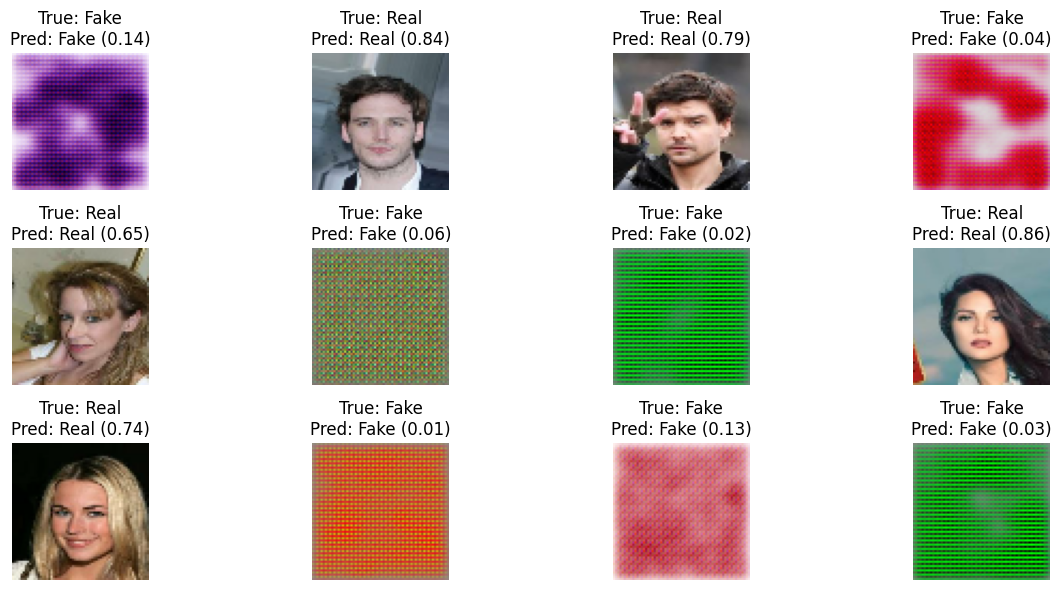

In [ ]:
# === Step 7: Evaluate and Visualize ===
def visualize_predictions():
    sample_batch = next(iter(final_dataset))
    images, labels = sample_batch
    preds = classifier.predict(images)

    plt.figure(figsize=(13, 6))
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy())
        true_label = "Real" if labels[i] == 1 else "Fake"
        pred_label = "Real" if preds[i] >= 0.5 else "Fake"
        plt.title(f"True: {true_label}\nPred: {pred_label} ({preds[i][0]:.2f})")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


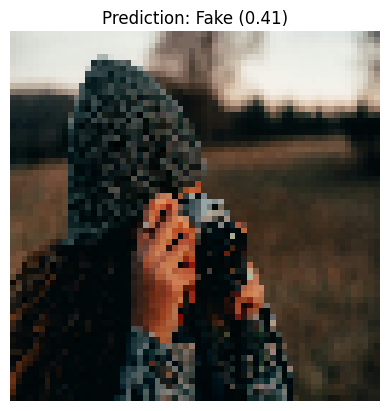

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_single_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    pred = classifier.predict(img_array)[0][0]
    label = "Real" if pred >= 0.5 else "Fake"

    # Visualize
    plt.imshow(img_array[0])
    plt.title(f"Prediction: {label} ({pred:.2f})")
    plt.axis("off")
    plt.show()

# Example usage
predict_single_image("/pic.jpg")
